# Revisión y exploración de bases de datos.

## Importación librerías

In [32]:
import pandas as pd
import numpy as np
import scipy.stats as stats 
import seaborn as sns
import matplotlib.pyplot as plt

## Importación bases de datos

In [2]:
# Games
games = pd.read_parquet("../Data/final/games_final.parquet")
# Reviews
reviews = pd.read_parquet("../Data/final/reviews_final.parquet")
# Items
items = pd.read_parquet("../Data/final/items_final.parquet")

## Exploración

In [3]:
# Se deciden unir todas las bases de datos en un mismo dataframe en el que se especifiquen: 
    # Horas totales jugadas para el juego.
    # Número de recomendaciones (Recommend = True)
    # Número de no recomendaciones (Recommend = False)
    # Puntaje de análisis de sentimiento (sentiment_analysis)

In [4]:
# Con este propósito, se identifica el número de recomendaciones positivas por juego:
positivas = reviews[reviews["recommend"] == True]
positivas = positivas.groupby("item_id")["recommend"].count().reset_index()

# El número de recomendaciones negativas:
negativas = reviews[reviews["recommend"] == False]
negativas = negativas.groupby("item_id")["recommend"].count().reset_index()

# El puntaje de análisis de sentimiento:
sentimiento = reviews[["item_id","sentiment_analysis"]]
sentimiento = sentimiento.groupby("item_id").sum().reset_index()

# Las horas totales jugadas por juego
horas = items.groupby("item_id")["playtime_forever"].sum().reset_index()


In [77]:
# Se crea el dataframe uniendo la información obtenida en el punto anterior.
tot1 = pd.merge(games,positivas,how="left",left_on="id",right_on="item_id") # Se une games y sus resultados de reviews positivas.
tot2 = pd.merge(tot1,negativas,how="left",left_on="id",right_on="item_id") # Se unen el dataframe total (tot) con los resultados de las reviews negativas.
tot3 = pd.merge(tot2,sentimiento,how="left",left_on="id",right_on="item_id") # Se unen el dataframe total con los resultados del análisis de sentimiento.
tot3.drop(columns=["item_id_x","item_id_y","item_id"],inplace=True) # Se eliminan del dataframe total las columnas repetidas de item_id.
total = pd.merge(tot3,horas,how="left",left_on="id",right_on="item_id") # Se unen el dataframe total con los resultados de la suma de horas totales jugadas por juego.
total.drop(columns="item_id",inplace=True) # Se elimina la columna repetida de item_id.

# Se cambian los nombres de las columnas para que sean más representativas
total.rename(columns={"recommend_x":"recommend","recommend_y":"no_recommend"},inplace=True)

# Con el propósito de contar con datos que contengan información en los cuatro datos agregados(recommend, no_recommend, sentiment_analysis, playtime_forever) se hacen las siguientes modificaciones:

# Se eliminan del dataframe todos los juegos que no tengan información en ninguno en los 3 campos de recomendación (recommend, no_recommend, sentiment_analysis)
total_l = total.dropna(subset=["recommend","no_recommend","sentiment_analysis"],how="all")
# De esta base se eliminan todos aquellos que no tengan horas en "playtime_forever"
total_l = total_l.dropna(subset=["playtime_forever"])
# Se reemplazan por cero los nulos faltantes
total_l.fillna(0,inplace=True)

In [78]:
# Se observa el dataframe
total_l

,id,genres,app_name,release_date,recommend,no_recommend,sentiment_analysis,playtime_forever
0,10,[Action],Counter-Strike,2000-11-01,29.0,1.0,50.0,51279.69
1,20,[Action],Team Fortress Classic,1999-04-01,6.0,5.0,17.0,6363.10
2,30,[Action],Day of Defeat,2003-05-01,3.0,0.0,5.0,6596.96
3,40,[Action],Deathmatch Classic,2001-06-01,1.0,0.0,2.0,845.33
4,50,[Action],Half-Life: Opposing Force,1999-11-01,3.0,1.0,5.0,5082.69
...,...,...,...,...,...,...,...,...
17586,514520,[Indie],Sparky's Hunt,2016-08-18,1.0,0.0,2.0,0.57
17649,516040,"[Indie, Strategy]",Everything is Peachy,2016-08-25,1.0,0.0,2.0,0.68
17816,521340,"[Casual, Indie]",True or False,2016-09-16,1.0,0.0,2.0,13.32
17854,521990,"[Action, Indie]",Galactic Storm,2016-09-16,1.0,0.0,2.0,0.27


In [79]:
# Se observa información sobre la base obtenida.
total_l.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2555 entries, 0 to 18113
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  2555 non-null   int64         
 1   genres              2555 non-null   object        
 2   app_name            2555 non-null   object        
 3   release_date        2555 non-null   datetime64[ns]
 4   recommend           2555 non-null   float64       
 5   no_recommend        2555 non-null   float64       
 6   sentiment_analysis  2555 non-null   float64       
 7   playtime_forever    2555 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 179.6+ KB


In [80]:
# Debido a que los datos en "genre" aparecen como un numpyarray:
print(type(total_l.loc[0,"genres"]))

# Se deciden convertir los datos a una lista.
total_l["genres"] = total_l["genres"].apply(lambda x: x.tolist())
print(type(total_l.loc[0,"genres"]))

<class 'numpy.ndarray'>
<class 'list'>


Se desean conocer las variaciones de los diferentes tipos de datos por la categoría a la que pertenecen.

In [93]:
# Se hace un explode en los géneros con el propósito de obtener estas variables como categorías dummies.
generos = total_l["genres"].explode()

x = pd.get_dummies(generos, prefix="genre") # Se obtiene la separación categórica por género.
total_generos = pd.concat([total_l,x.groupby(x.index).sum()],axis=1) # Se une con el dataframe original, tomando como base el index.
total_generos.drop(columns = "genres",inplace=True)

In [94]:
# Se observa el dataframe obtenido.
total_generos

,id,app_name,release_date,recommend,no_recommend,sentiment_analysis,playtime_forever,genre_Action,genre_Adventure,genre_Casual,genre_Early Access,genre_Free to Play,genre_Indie,genre_RPG,genre_Simulation,genre_Sports,genre_Strategy
0,10,Counter-Strike,2000-11-01,29.0,1.0,50.0,51279.69,1,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,6.0,5.0,17.0,6363.10,1,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,3.0,0.0,5.0,6596.96,1,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,1.0,0.0,2.0,845.33,1,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,3.0,1.0,5.0,5082.69,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17586,514520,Sparky's Hunt,2016-08-18,1.0,0.0,2.0,0.57,0,0,0,0,0,1,0,0,0,0
17649,516040,Everything is Peachy,2016-08-25,1.0,0.0,2.0,0.68,0,0,0,0,0,1,0,0,0,1
17816,521340,True or False,2016-09-16,1.0,0.0,2.0,13.32,0,0,1,0,0,1,0,0,0,0
17854,521990,Galactic Storm,2016-09-16,1.0,0.0,2.0,0.27,1,0,0,0,0,1,0,0,0,0


In [95]:
# Se observa la base obtenida
total_generos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2555 entries, 0 to 18113
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  2555 non-null   int64         
 1   app_name            2555 non-null   object        
 2   release_date        2555 non-null   datetime64[ns]
 3   recommend           2555 non-null   float64       
 4   no_recommend        2555 non-null   float64       
 5   sentiment_analysis  2555 non-null   float64       
 6   playtime_forever    2555 non-null   float64       
 7   genre_Action        2555 non-null   int64         
 8   genre_Adventure     2555 non-null   int64         
 9   genre_Casual        2555 non-null   int64         
 10  genre_Early Access  2555 non-null   int64         
 11  genre_Free to Play  2555 non-null   int64         
 12  genre_Indie         2555 non-null   int64         
 13  genre_RPG           2555 non-null   int64         
 

In [96]:
total_generos.describe()

,id,release_date,recommend,no_recommend,sentiment_analysis,playtime_forever,genre_Action,genre_Adventure,genre_Casual,genre_Early Access,genre_Free to Play,genre_Indie,genre_RPG,genre_Simulation,genre_Sports,genre_Strategy
count,2555.000000,2555,2555.000000,2555.000000,2555.000000,2.555000e+03,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000,2555.000000
mean,249405.645010,2013-01-15 21:10:55.185910016,11.798043,1.577691,20.055186,1.047400e+04,0.533855,0.327202,0.183562,0.053229,0.120157,0.558121,0.216047,0.172994,0.034834,0.233659
min,10.000000,1989-01-01 00:00:00,0.000000,0.000000,0.000000,2.000000e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,207770.000000,2012-02-11 00:00:00,1.000000,0.000000,2.000000,1.094000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,268050.000000,2014-05-15 00:00:00,2.000000,0.000000,3.000000,4.407900e+02,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,342265.000000,2015-08-03 00:00:00,6.000000,1.000000,10.000000,2.124600e+03,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,527340.000000,2017-12-25 00:00:00,2278.000000,212.000000,3619.000000,4.800734e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,130057.043385,NaN,61.291407,7.115870,98.951249,1.216566e+05,0.498950,0.469283,0.387202,0.224534,0.325208,0.496708,0.411627,0.378316,0.183394,0.423241


In [97]:
# Se guarda la base obtenida.
total_generos.to_parquet("../Data/final/total_generos.parquet")

In [101]:
# Se carga el dataframe obtenido para revisar que haya quedado correctamente guardado.
total_generos = pd.read_parquet("../Data/final/total_generos.parquet")
total_generos.head()

,id,app_name,release_date,recommend,no_recommend,sentiment_analysis,playtime_forever,genre_Action,genre_Adventure,genre_Casual,genre_Early Access,genre_Free to Play,genre_Indie,genre_RPG,genre_Simulation,genre_Sports,genre_Strategy
0,10,Counter-Strike,2000-11-01,29.0,1.0,50.0,51279.69,1,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,6.0,5.0,17.0,6363.10,1,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,3.0,0.0,5.0,6596.96,1,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,1.0,0.0,2.0,845.33,1,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,3.0,1.0,5.0,5082.69,1,0,0,0,0,0,0,0,0,0


In [99]:
# Se observan outliers por playtime_forever
x = total_generos
x["valor_z"] = stats.zscore(x["playtime_forever"])
x = x[(x["valor_z"] < -3) | (x["valor_z"] > 3)]
x

# Se deciden no eliminar los juegos reconocidos como outiliers ya que son juegos muy populares.

,id,app_name,release_date,recommend,no_recommend,sentiment_analysis,playtime_forever,genre_Action,genre_Adventure,genre_Casual,genre_Early Access,genre_Free to Play,genre_Indie,genre_RPG,genre_Simulation,genre_Sports,genre_Strategy,valor_z
10,240,Counter-Strike: Source,2004-11-01,159.0,7.0,255.0,466416.34,1,0,0,0,0,0,0,0,0,0,3.748515
21,550,Left 4 Dead 2,2009-11-16,426.0,15.0,656.0,507782.93,1,0,0,0,0,0,0,0,0,0,4.088609
24,730,Counter-Strike: Global Offensive,2012-08-21,2278.0,212.0,3619.0,4800733.65,1,0,0,0,0,0,0,0,0,0,39.382965
141,4000,Garry's Mod,2006-11-29,1168.0,42.0,1882.0,3291533.13,0,0,0,0,0,1,0,1,0,0,26.975122
250,8930,Sid Meier's Civilization® V,2010-09-21,272.0,7.0,441.0,464729.86,0,0,0,0,0,0,0,0,0,1,3.734650
1242,49520,Borderlands 2,2012-09-17,401.0,9.0,666.0,473330.80,1,0,0,0,0,0,1,0,0,0,3.805362
1724,105600,Terraria,2011-05-16,515.0,15.0,835.0,950732.14,1,1,0,0,0,1,1,0,0,0,7.730302
1733,107410,Arma 3,2013-09-12,183.0,24.0,311.0,470227.62,1,0,0,0,0,0,0,1,0,1,3.779850
3268,230410,Warframe,2013-03-25,386.0,24.0,658.0,718530.87,1,0,0,0,1,0,0,0,0,0,5.821267
3949,252490,Rust,2013-12-11,536.0,86.0,886.0,549089.02,1,1,0,1,0,1,1,0,0,0,4.428206


C:\Users\dmon2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


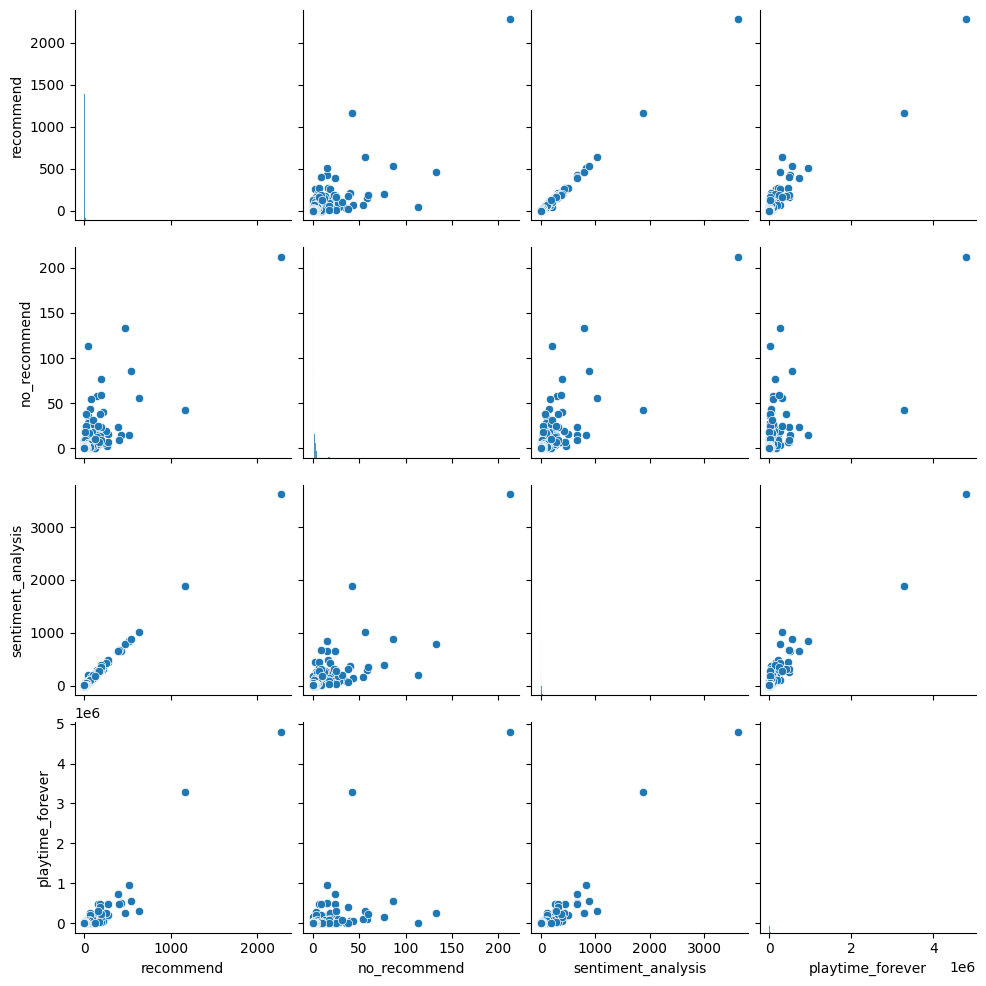

In [104]:
# Se observan las relaciones entre las variables agregadas (recommend, no_recommend, sentiment_analysis, playtime_forever)
sns.pairplot(total_generos[["recommend","no_recommend","sentiment_analysis","playtime_forever"]])

<Axes: >

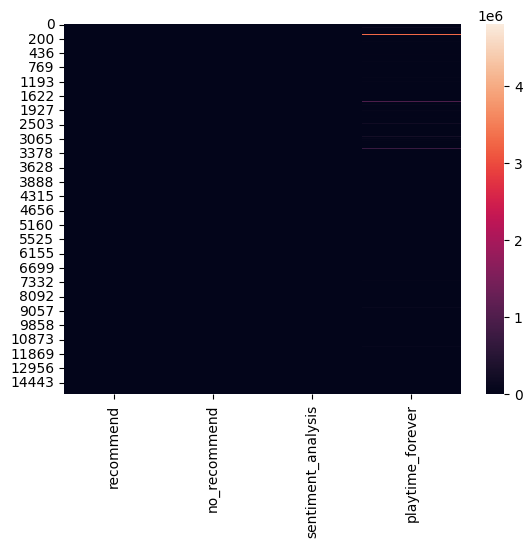

In [105]:
# Heatmap de las relaciones entre las variables.
sns.heatmap(total_generos[["recommend","no_recommend","sentiment_analysis","playtime_forever"]])